# Covid-19 Mexico Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Link para descargar bases de datos: https://web.archive.org/web/20220122063317/http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/historicos/08/datos_abiertos_covid19_30.08.2020.zip

In [2]:
data = pd.read_csv('/Users/ro/Downloads/200801COVID19MEXICO.csv', encoding='latin1')

#Convert object to date time format
data['FECHA_INGRESO'] = pd.to_datetime(data['FECHA_INGRESO'])
data['FECHA_SINTOMAS'] = pd.to_datetime(data['FECHA_SINTOMAS'])
data['FECHA_DEF'].replace('9999-99-99', pd.NaT, inplace=True)
data['FECHA_DEF'] = pd.to_datetime(data['FECHA_DEF'])

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_18928/3856416641.py:1: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/Users/ro/Downloads/200801COVID19MEXICO.csv', encoding='latin1')


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999697 entries, 0 to 999696
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   FECHA_ACTUALIZACION  999697 non-null  object        
 1   ID_REGISTRO          999697 non-null  object        
 2   ORIGEN               999697 non-null  int64         
 3   SECTOR               999697 non-null  int64         
 4   ENTIDAD_UM           999697 non-null  int64         
 5   SEXO                 999697 non-null  int64         
 6   ENTIDAD_NAC          999697 non-null  int64         
 7   ENTIDAD_RES          999697 non-null  int64         
 8   MUNICIPIO_RES        999697 non-null  int64         
 9   TIPO_PACIENTE        999697 non-null  int64         
 10  FECHA_INGRESO        999697 non-null  datetime64[ns]
 11  FECHA_SINTOMAS       999697 non-null  datetime64[ns]
 12  FECHA_DEF            61264 non-null   datetime64[ns]
 13  INTUBADO      

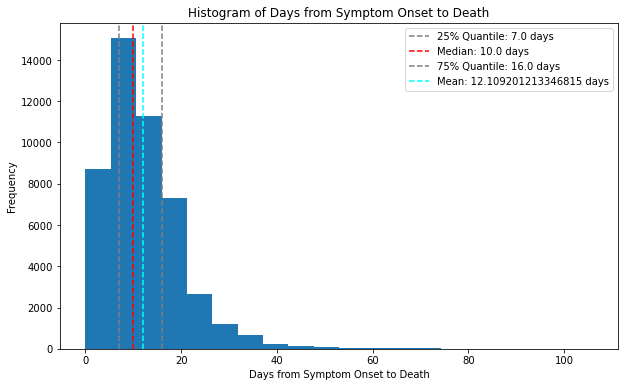

In [3]:
confirmados = data[data['RESULTADO']==1].copy()
confirmados['OnsetToDeath'] = (confirmados['FECHA_DEF']-confirmados['FECHA_SINTOMAS']).dt.days

plt.figure(figsize=(10, 6))
plt.hist(confirmados['OnsetToDeath'],bins=20)
plt.xlabel('Days from Symptom Onset to Death')
plt.ylabel('Frequency')
plt.title('Histogram of Days from Symptom Onset to Death')

# Important statistics
q25 = confirmados['OnsetToDeath'].quantile(0.25)
q75 = confirmados['OnsetToDeath'].quantile(0.75)
median_value = confirmados['OnsetToDeath'].median()
mean_value = confirmados['OnsetToDeath'].mean()

# Add vertical lines for median and mode
plt.axvline(q25, color='grey', linestyle='--', label=f'25% Quantile: {q25} days')
plt.axvline(median_value, color='red', linestyle='--', label=f'Median: {median_value} days')
plt.axvline(q75, color='grey', linestyle='--', label=f'75% Quantile: {q75} days')
plt.axvline(mean_value, color='cyan', linestyle='--', label=f'Mean: {mean_value} days')


plt.legend()  # Show legend with median and mode labels

plt.show()

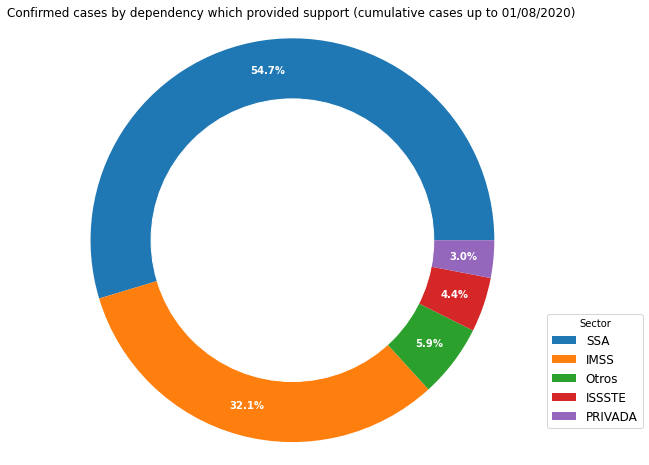

In [4]:
# Diccionario con el nombre correspondiente a cada sector
CodigoSector = {
    1: 'CRUZ ROJA',
    2: 'DIF',
    3: 'ESTATAL',
    4: 'IMSS',
    5: 'IMSS-BIENESTAR',
    6: 'ISSSTE',
    7: 'MUNICIPAL',
    8: 'PEMEX',
    9: 'PRIVADA',
    10: 'SEDENA',
    11: 'SEMAR',
    12: 'SSA',
    13: 'UNIVERSITARIO'
}

# Contamos casos registrados por cada sector
CasosSector = confirmados['SECTOR'].value_counts()

# Calculamos el % de casos por sector
CasosTotales = CasosSector.sum()
PorcentajesSector = CasosSector / CasosTotales * 100

# Agrupamos todos los sectores con menor participación del 3%
Otros = PorcentajesSector[PorcentajesSector < 3].index
confirmados.loc[confirmados['SECTOR'].isin(Otros), 'SECTOR'] = 'Otros'

# Recalculamos casos por sector y ordenamos de menor a mayor
CasosSector = confirmados['SECTOR'].value_counts()

# Graficamos
fig, ax = plt.subplots(figsize=(8, 8))
patches, texts, autotexts = ax.pie(CasosSector,autopct='%1.1f%%', pctdistance=0.85)
ax.axis('equal')
center_circle = plt.Circle((0, 0), 0.7, color='white')
ax.add_artist(center_circle)

for autotext in autotexts:
    autotext.set_color('white')  
    autotext.set_fontweight('bold') 

plt.legend(patches,[CodigoSector.get(key,'Otros') for key in CasosSector.index], loc="center right", bbox_to_anchor=(1.3,0.2), fontsize='large', title='Sector')
plt.title('Confirmed cases by dependency which provided support (cumulative cases up to 01/08/2020)')
plt.show()

In [5]:
# Group confirmed cases by date and state
confirmed_cases_grouped = confirmados.groupby(['FECHA_SINTOMAS', 'ENTIDAD_RES']).size().reset_index(name='confirmed_cases')
confirmed_deaths_grouped = confirmados.groupby(['FECHA_DEF', 'ENTIDAD_RES']).size().reset_index(name='confirmed_deaths')

confirmed_cases_grouped.rename(columns={'FECHA_SINTOMAS':'FECHA'}, inplace=True)
confirmed_deaths_grouped.rename(columns={'FECHA_DEF':'FECHA'}, inplace=True)

time_series = pd.merge(confirmed_cases_grouped, confirmed_deaths_grouped, how='outer', on=['FECHA', 'ENTIDAD_RES']).fillna(0)

national = time_series.groupby('FECHA').agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
national[-7:]

,FECHA,confirmed_cases,confirmed_deaths
159,2020-07-26,1694.0,440.0
160,2020-07-27,1597.0,332.0
161,2020-07-28,797.0,356.0
162,2020-07-29,372.0,296.0
163,2020-07-30,62.0,294.0
164,2020-07-31,14.0,90.0
165,2020-08-01,0.0,3.0


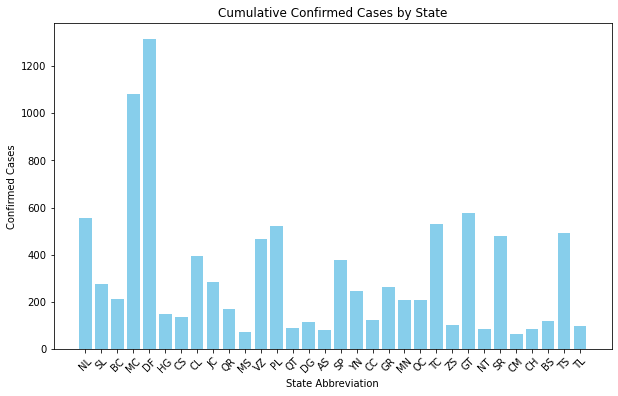

In [6]:
# Create the dictionary
state_codes = {
    '1': {'ENTIDAD_FEDERATIVA': 'AGUASCALIENTES', 'ABREVIATURA': 'AS'},
    '2': {'ENTIDAD_FEDERATIVA': 'BAJA CALIFORNIA', 'ABREVIATURA': 'BC'},
    '3': {'ENTIDAD_FEDERATIVA': 'BAJA CALIFORNIA SUR', 'ABREVIATURA': 'BS'},
    '4': {'ENTIDAD_FEDERATIVA': 'CAMPECHE', 'ABREVIATURA': 'CC'},
    '5': {'ENTIDAD_FEDERATIVA': 'COAHUILA DE ZARAGOZA', 'ABREVIATURA': 'CL'},
    '6': {'ENTIDAD_FEDERATIVA': 'COLIMA', 'ABREVIATURA': 'CM'},
    '7': {'ENTIDAD_FEDERATIVA': 'CHIAPAS', 'ABREVIATURA': 'CS'},
    '8': {'ENTIDAD_FEDERATIVA': 'CHIHUAHUA', 'ABREVIATURA': 'CH'},
    '9': {'ENTIDAD_FEDERATIVA': 'CIUDAD DE MÉXICO', 'ABREVIATURA': 'DF'},
    '10': {'ENTIDAD_FEDERATIVA': 'DURANGO', 'ABREVIATURA': 'DG'},
    '11': {'ENTIDAD_FEDERATIVA': 'GUANAJUATO', 'ABREVIATURA': 'GT'},
    '12': {'ENTIDAD_FEDERATIVA': 'GUERRERO', 'ABREVIATURA': 'GR'},
    '13': {'ENTIDAD_FEDERATIVA': 'HIDALGO', 'ABREVIATURA': 'HG'},
    '14': {'ENTIDAD_FEDERATIVA': 'JALISCO', 'ABREVIATURA': 'JC'},
    '15': {'ENTIDAD_FEDERATIVA': 'MÉXICO', 'ABREVIATURA': 'MC'},
    '16': {'ENTIDAD_FEDERATIVA': 'MICHOACÁN DE OCAMPO', 'ABREVIATURA': 'MN'},
    '17': {'ENTIDAD_FEDERATIVA': 'MORELOS', 'ABREVIATURA': 'MS'},
    '18': {'ENTIDAD_FEDERATIVA': 'NAYARIT', 'ABREVIATURA': 'NT'},
    '19': {'ENTIDAD_FEDERATIVA': 'NUEVO LEÓN', 'ABREVIATURA': 'NL'},
    '20': {'ENTIDAD_FEDERATIVA': 'OAXACA', 'ABREVIATURA': 'OC'},
    '21': {'ENTIDAD_FEDERATIVA': 'PUEBLA', 'ABREVIATURA': 'PL'},
    '22': {'ENTIDAD_FEDERATIVA': 'QUERÉTARO', 'ABREVIATURA': 'QT'},
    '23': {'ENTIDAD_FEDERATIVA': 'QUINTANA ROO', 'ABREVIATURA': 'QR'},
    '24': {'ENTIDAD_FEDERATIVA': 'SAN LUIS POTOSÍ', 'ABREVIATURA': 'SP'},
    '25': {'ENTIDAD_FEDERATIVA': 'SINALOA', 'ABREVIATURA': 'SL'},
    '26': {'ENTIDAD_FEDERATIVA': 'SONORA', 'ABREVIATURA': 'SR'},
    '27': {'ENTIDAD_FEDERATIVA': 'TABASCO', 'ABREVIATURA': 'TC'},
    '28': {'ENTIDAD_FEDERATIVA': 'TAMAULIPAS', 'ABREVIATURA': 'TS'},
    '29': {'ENTIDAD_FEDERATIVA': 'TLAXCALA', 'ABREVIATURA': 'TL'},
    '30': {'ENTIDAD_FEDERATIVA': 'VERACRUZ DE IGNACIO DE LA LLAVE', 'ABREVIATURA': 'VZ'},
    '31': {'ENTIDAD_FEDERATIVA': 'YUCATÁN', 'ABREVIATURA': 'YN'},
    '32': {'ENTIDAD_FEDERATIVA': 'ZACATECAS', 'ABREVIATURA': 'ZS'},
    }

# Convert state codes to strings
state_codes_str = {str(code): state for code, state in state_codes.items()}

# Map state codes to their corresponding abbreviations or full names
state_labels = [state_codes_str.get(str(code), {}).get('ABREVIATURA', 'Unknown') for code in time_series['ENTIDAD_RES']]

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(state_labels, time_series['confirmed_cases'], color='skyblue')

# Set the labels and title
plt.xlabel('State Abbreviation')  # You can change this to 'State Name' if you prefer
plt.ylabel('Confirmed Cases')
plt.title('Cumulative Confirmed Cases by State')


# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

## Motivation (delay in registered deaths)

In [7]:
data2 = pd.read_csv('/Users/ro/Downloads/200808COVID19MEXICO.csv', encoding='latin1')
#Convert object to date time format
data2['FECHA_INGRESO'] = pd.to_datetime(data2['FECHA_INGRESO'])
data2['FECHA_SINTOMAS'] = pd.to_datetime(data2['FECHA_SINTOMAS'])
data2['FECHA_DEF'].replace('9999-99-99', pd.NaT, inplace=True)
data2['FECHA_DEF'] = pd.to_datetime(data2['FECHA_DEF'])

In [8]:
confirmados2 = data2[data2['RESULTADO']==1].copy()
confirmados2['OnsetToDeath'] = (confirmados2['FECHA_DEF']-confirmados2['FECHA_SINTOMAS']).dt.days

In [9]:
# Group confirmed cases by date and state
confirmed_cases2_grouped = confirmados2.groupby(['FECHA_SINTOMAS', 'ENTIDAD_RES']).size().reset_index(name='confirmed_cases')
confirmed_deaths2_grouped = confirmados2.groupby(['FECHA_DEF', 'ENTIDAD_RES']).size().reset_index(name='confirmed_deaths')

confirmed_cases2_grouped.rename(columns={'FECHA_SINTOMAS':'FECHA'}, inplace=True)
confirmed_deaths2_grouped.rename(columns={'FECHA_DEF':'FECHA'}, inplace=True)

time_series2 = pd.merge(confirmed_cases2_grouped, confirmed_deaths2_grouped, how='outer', on=['FECHA', 'ENTIDAD_RES']).fillna(0)

In [10]:
national2 = time_series2.groupby('FECHA').agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
national2[-14:-7]

,FECHA,confirmed_cases,confirmed_deaths
159,2020-07-26,4366.0,516.0
160,2020-07-27,5303.0,452.0
161,2020-07-28,4165.0,469.0
162,2020-07-29,3416.0,452.0
163,2020-07-30,2952.0,495.0
164,2020-07-31,2733.0,449.0
165,2020-08-01,3085.0,453.0


In [11]:
data3 = pd.read_csv('/Users/ro/Downloads/200815COVID19MEXICO.csv', encoding='latin1')
#Convert object to date time format
data3['FECHA_INGRESO'] = pd.to_datetime(data3['FECHA_INGRESO'])
data3['FECHA_SINTOMAS'] = pd.to_datetime(data3['FECHA_SINTOMAS'])
data3['FECHA_DEF'].replace('9999-99-99', pd.NaT, inplace=True)
data3['FECHA_DEF'] = pd.to_datetime(data3['FECHA_DEF'])
confirmados3 = data3[data3['RESULTADO']==1].copy()
confirmados3['OnsetToDeath'] = (confirmados3['FECHA_DEF']-confirmados3['FECHA_SINTOMAS']).dt.days

In [12]:
# Group confirmed cases by date and state
confirmed_cases3_grouped = confirmados3.groupby(['FECHA_SINTOMAS', 'ENTIDAD_RES']).size().reset_index(name='confirmed_cases')
confirmed_deaths3_grouped = confirmados3.groupby(['FECHA_DEF', 'ENTIDAD_RES']).size().reset_index(name='confirmed_deaths')

confirmed_cases3_grouped.rename(columns={'FECHA_SINTOMAS':'FECHA'}, inplace=True)
confirmed_deaths3_grouped.rename(columns={'FECHA_DEF':'FECHA'}, inplace=True)

time_series3 = pd.merge(confirmed_cases3_grouped, confirmed_deaths3_grouped, how='outer', on=['FECHA', 'ENTIDAD_RES']).fillna(0)

In [13]:
national3 = time_series3.groupby('FECHA').agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
national3[-21:-14]

,FECHA,confirmed_cases,confirmed_deaths
159,2020-07-26,5012.0,575.0
160,2020-07-27,6375.0,590.0
161,2020-07-28,5223.0,577.0
162,2020-07-29,4446.0,483.0
163,2020-07-30,4441.0,544.0
164,2020-07-31,4637.0,486.0
165,2020-08-01,6557.0,502.0


In [14]:
(national[['confirmed_cases', 'confirmed_deaths']][-7:].reset_index(drop=True) /
          national3[['confirmed_cases','confirmed_deaths']][-21:-14].reset_index(drop=True))*100

,confirmed_cases,confirmed_deaths
0,33.798883,76.521739
1,25.050980,56.271186
2,15.259429,61.698440
3,8.367072,61.283644
4,1.396082,54.044118
5,0.301919,18.518519
6,0.000000,0.597610


In [15]:
(national2[['confirmed_cases','confirmed_deaths']][-14:-7].reset_index(drop=True) / 
        national3[['confirmed_cases','confirmed_deaths']][-21:-14].reset_index(drop=True))*100

,confirmed_cases,confirmed_deaths
0,87.110934,89.739130
1,83.184314,76.610169
2,79.743442,81.282496
3,76.833108,93.581781
4,66.471515,90.992647
5,58.938969,92.386831
6,47.048955,90.239044


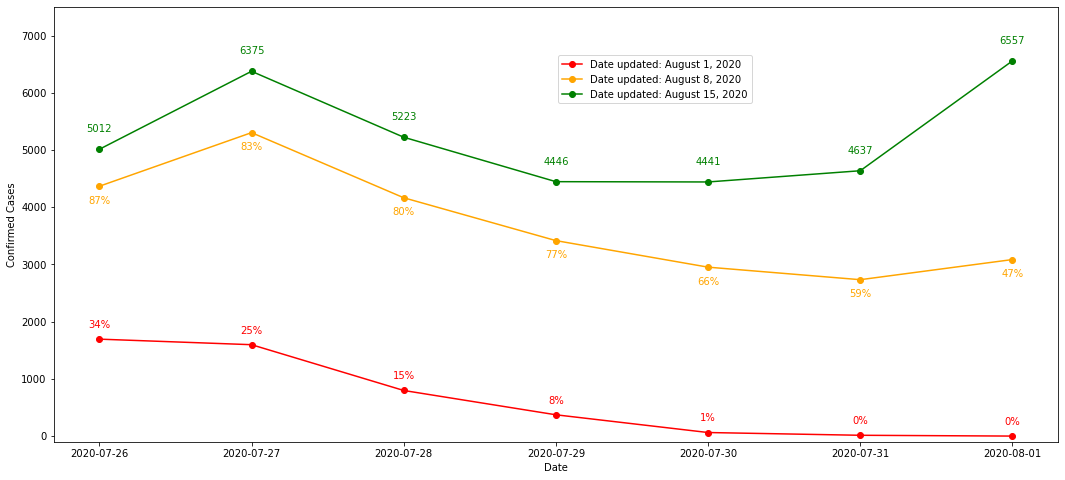

In [16]:
plt.figure(figsize=(18, 8))

plt.plot(national[-7:]['FECHA'], national[-7:]['confirmed_cases'], color='red', marker='o', label='Date updated: August 1, 2020')
plt.plot(national2[-14:-7]['FECHA'], national2[-14:-7]['confirmed_cases'], color='orange', marker='o', label='Date updated: August 8, 2020')
plt.plot(national3[-21:-14]['FECHA'], national3[-21:-14]['confirmed_cases'], color='green', marker='o', label='Date updated: August 15, 2020')

# Calculate percentages for national2[-14:-7] and national[-7:]
percentage_national2 = (national2[-14:-7]['confirmed_cases'] / national3[-21:-14]['confirmed_cases'])*100
percentage_national = (national[-7:]['confirmed_cases'] / national3[-21:-14]['confirmed_cases'])*100

# Add percentage labels
for i in range(len(national3[-21:-14])):
    plt.text(national3[-21:-14].iloc[i]['FECHA'], national3[-21:-14].iloc[i]['confirmed_cases']+300, f"{national3[-21:-14].iloc[i]['confirmed_cases']:.0f}", ha='center',fontsize=10, color='green')

for i in range(len(national2[-14:-7])):
    plt.text(national2[-14:-7].iloc[i]['FECHA'], national2[-14:-7].iloc[i]['confirmed_cases']-300, f"{percentage_national2.iloc[i]:.0f}%", ha='center',fontsize=10, color='orange')

for i in range(len(national[-7:])):
    plt.text(national[-7:].iloc[i]['FECHA'], national[-7:].iloc[i]['confirmed_cases']+200, f"{percentage_national.iloc[i]:.0f}%", ha='center',fontsize=10, color='red')

plt.ylim(-100,7500)
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.legend(loc='upper right', bbox_to_anchor=(0.7, 0.9))
plt.show()

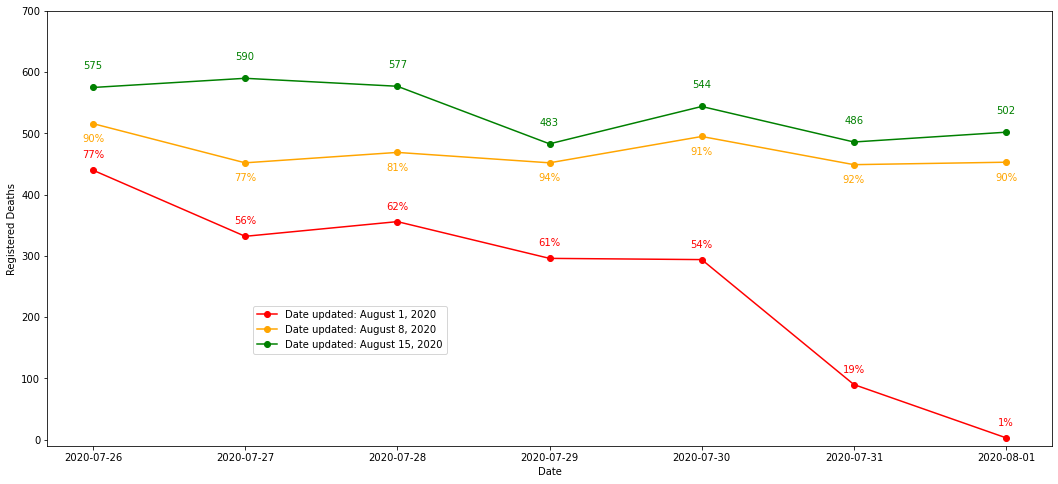

In [17]:
plt.figure(figsize=(18, 8))

plt.plot(national[-7:]['FECHA'], national[-7:]['confirmed_deaths'], color='red', marker='o', label='Date updated: August 1, 2020')
plt.plot(national2[-14:-7]['FECHA'], national2[-14:-7]['confirmed_deaths'], color='orange', marker='o', label='Date updated: August 8, 2020')
plt.plot(national3[-21:-14]['FECHA'], national3[-21:-14]['confirmed_deaths'], color='green', marker='o', label='Date updated: August 15, 2020')

# Calculate percentages for national2[-14:-7] and national[-7:]
d_percentage_national2 = (national2[-14:-7]['confirmed_deaths'] / national3[-21:-14]['confirmed_deaths'])*100
d_percentage_national = (national[-7:]['confirmed_deaths'] / national3[-21:-14]['confirmed_deaths'])*100

# Add percentage labels
for i in range(len(national3[-21:-14])):
    plt.text(national3[-21:-14].iloc[i]['FECHA'], national3[-21:-14].iloc[i]['confirmed_deaths']+30, f"{national3[-21:-14].iloc[i]['confirmed_deaths']:.0f}", ha='center',fontsize=10, color='green')

for i in range(len(national2[-14:-7])):
    plt.text(national2[-14:-7].iloc[i]['FECHA'], national2[-14:-7].iloc[i]['confirmed_deaths']-30, f"{d_percentage_national2.iloc[i]:.0f}%", ha='center',fontsize=10, color='orange')

for i in range(len(national[-7:])):
    plt.text(national[-7:].iloc[i]['FECHA'], national[-7:].iloc[i]['confirmed_deaths']+20, f"{d_percentage_national.iloc[i]:.0f}%", ha='center',fontsize=10, color='red')

plt.ylim(-10,700)
plt.xlabel('Date')
plt.ylabel('Registered Deaths')
plt.legend(loc='lower left', bbox_to_anchor=(0.2, 0.2))
plt.show()

## EDA for 2024 COVID-19 Mexico Data

Source: 
* https://www.gob.mx/salud/documentos/datos-abiertos-bases-historicas-direccion-general-de-epidemiologia

In [33]:
#Read downloaded databases split by years
DB_names = ['COVID19MEXICO-7.csv','230425COVID19MEXICO.csv','COVID19MEXICO2021.csv','COVID19MEXICO2020.csv']

data_2020 = pd.read_csv('/Users/ro/Downloads/COVID19MEXICO2020.csv', encoding='latin1')
data_2021 = pd.read_csv('/Users/ro/Downloads/COVID19MEXICO2021.csv', encoding='latin1')
data_2022 = pd.read_csv('/Users/ro/Downloads/230425COVID19MEXICO.csv', encoding='latin1')
data_2023 = pd.read_csv('/Users/ro/Downloads/COVID19MEXICO-7.csv', encoding='latin1')

/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_18928/102681277.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2020 = pd.read_csv('/Users/ro/Downloads/COVID19MEXICO2020.csv', encoding='latin1')
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_18928/102681277.py:5: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2021 = pd.read_csv('/Users/ro/Downloads/COVID19MEXICO2021.csv', encoding='latin1')
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_18928/102681277.py:6: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2022 = pd.read_csv('/Users/ro/Downloads/230425COVID19MEXICO.csv', encoding='latin1')
/var/folders/4x/6c9p63ls07x580slpnw2nx2h0000gn/T/ipykernel_18928/102681277.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.


In [34]:
# Remove duplicate date entries between 2022 and 2023 databases
remove_dates = data_2022['FECHA_SINTOMAS'] >= '2023-01-01'
data_2022.drop(data_2022[remove_dates].index, inplace=True)

In [35]:
# Convert to date-time format 
data_2020['FECHA_ACTUALIZACION'] = pd.to_datetime(data_2020['FECHA_ACTUALIZACION']).dt.date
data_2020['FECHA_INGRESO'] = pd.to_datetime(data_2020['FECHA_INGRESO']).dt.date
data_2020['FECHA_SINTOMAS'] = pd.to_datetime(data_2020['FECHA_SINTOMAS']).dt.date
data_2020['FECHA_DEF'].replace('9999-99-99', pd.NaT, inplace=True)
data_2020['FECHA_DEF'] = pd.to_datetime(data_2020['FECHA_DEF']).dt.date

data_2021['FECHA_ACTUALIZACION'] = pd.to_datetime(data_2021['FECHA_ACTUALIZACION']).dt.date
data_2021['FECHA_INGRESO'] = pd.to_datetime(data_2021['FECHA_INGRESO']).dt.date
data_2021['FECHA_SINTOMAS'] = pd.to_datetime(data_2021['FECHA_SINTOMAS']).dt.date
data_2021['FECHA_DEF'].replace('9999-99-99', pd.NaT, inplace=True)
data_2021['FECHA_DEF'] = pd.to_datetime(data_2021['FECHA_DEF']).dt.date

data_2022['FECHA_ACTUALIZACION'] = pd.to_datetime(data_2022['FECHA_ACTUALIZACION']).dt.date
data_2022['FECHA_INGRESO'] = pd.to_datetime(data_2022['FECHA_INGRESO']).dt.date
data_2022['FECHA_SINTOMAS'] = pd.to_datetime(data_2022['FECHA_SINTOMAS']).dt.date
data_2022['FECHA_DEF'].replace('9999-99-99', pd.NaT, inplace=True)
data_2022['FECHA_DEF'] = pd.to_datetime(data_2022['FECHA_DEF']).dt.date

data_2023['FECHA_ACTUALIZACION'] = pd.to_datetime(data_2023['FECHA_ACTUALIZACION']).dt.date
data_2023['FECHA_INGRESO'] = pd.to_datetime(data_2023['FECHA_INGRESO']).dt.date
data_2023['FECHA_SINTOMAS'] = pd.to_datetime(data_2023['FECHA_SINTOMAS']).dt.date
data_2023['FECHA_DEF'].replace('9999-99-99', pd.NaT, inplace=True)
data_2023['FECHA_DEF'] = pd.to_datetime(data_2023['FECHA_DEF']).dt.date


In [188]:
#Filter confirmed cases only
filter_2020 = data_2020['CLASIFICACION_FINAL'].isin([1,2,3])
filter_2021 = data_2021['CLASIFICACION_FINAL'].isin([1,2,3])
filter_2022 = data_2022['CLASIFICACION_FINAL'].isin([1,2,3])
filter_2023 = data_2023['CLASIFICACION_FINAL'].isin([1,2,3])

confirmed_2020 = data_2020.loc[filter_2020].reset_index(drop=True).copy()
confirmed_2021 = data_2021.loc[filter_2021].reset_index(drop=True).copy()
confirmed_2022 = data_2022.loc[filter_2022].reset_index(drop=True).copy()
confirmed_2023 = data_2023.loc[filter_2023].reset_index(drop=True).copy()

In [189]:
#Add onset to death column
OTD2020 = (confirmed_2020['FECHA_DEF']-confirmed_2020['FECHA_SINTOMAS']).dt.days 
OTD2021 = (confirmed_2021['FECHA_DEF']-confirmed_2021['FECHA_SINTOMAS']).dt.days 
OTD2022 = (confirmed_2022['FECHA_DEF']-confirmed_2022['FECHA_SINTOMAS']).dt.days 
OTD2023 = (confirmed_2023['FECHA_DEF']-confirmed_2023['FECHA_SINTOMAS']).dt.days 

confirmed_2020.loc[:, 'OTD'] = OTD2020
confirmed_2021.loc[:, 'OTD'] = OTD2021
confirmed_2022.loc[:, 'OTD'] = OTD2022
confirmed_2023.loc[:, 'OTD'] = OTD2023

# Determine if there are any bad quality death data
print('Death Date before Symptoms Date in 2020: ', (OTD2020 < 0).sum())
print('Death Date before Symptoms Date in 2021: ', (OTD2021 < 0).sum())
print('Death Date before Symptoms Date in 2022: ', (OTD2022 < 0).sum())
print('Death Date before Symptoms Date in 2023: ', (OTD2023 < 0).sum())

Death Date before Symptoms Date in 2020:  9
Death Date before Symptoms Date in 2021:  0
Death Date before Symptoms Date in 2022:  1
Death Date before Symptoms Date in 2023:  0


In [190]:
#Remove wrong data entries i.e. Death Date < Symptoms Date
confirmed_2020 = confirmed_2020[(confirmed_2020['OTD'].isnull()) | (confirmed_2020['OTD'] >= 0)].reset_index(drop=True)
confirmed_2021 = confirmed_2021[(confirmed_2021['OTD'].isnull()) | (confirmed_2021['OTD'] >= 0)].reset_index(drop=True)
confirmed_2022 = confirmed_2022[(confirmed_2022['OTD'].isnull()) | (confirmed_2022['OTD'] >= 0)].reset_index(drop=True)
confirmed_2023 = confirmed_2023[(confirmed_2023['OTD'].isnull()) | (confirmed_2023['OTD'] >= 0)].reset_index(drop=True)

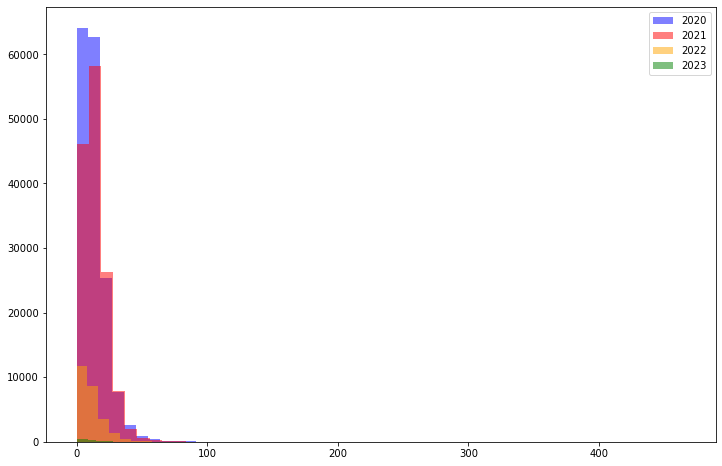

In [191]:
plt.figure(figsize=(12, 8))
plt.hist(confirmed_2020[confirmed_2020['OTD'] >= 0]['OTD'], color='blue', alpha=0.5, label='2020', bins = 50)
plt.hist(confirmed_2021[confirmed_2021['OTD'] >= 0]['OTD'], color='red', alpha=0.5, label='2021', bins = 50)
plt.hist(confirmed_2022[confirmed_2022['OTD'] >= 0]['OTD'], color='orange', alpha=0.5, label='2022', bins = 50)
plt.hist(confirmed_2023[confirmed_2023['OTD'] >= 0]['OTD'], color='green', alpha=0.5, label='2023', bins = 50)
plt.legend()
plt.show()

In [192]:
percentile_99_2020 = confirmed_2020[confirmed_2020['OTD'] >= 0]['OTD'].quantile(0.99)
percentile_99_2021 = confirmed_2021[confirmed_2021['OTD'] >= 0]['OTD'].quantile(0.99)
percentile_99_2022 = confirmed_2022[confirmed_2022['OTD'] >= 0]['OTD'].quantile(0.99)
percentile_99_2023 = confirmed_2023[confirmed_2023['OTD'] >= 0]['OTD'].quantile(0.99)

print("99% of 2020 deaths remains below:", percentile_99_2020)
print("99% of 2021 deaths remains below:", percentile_99_2021)
print("99% of 2022 deaths remains below:", percentile_99_2022)
print("99% of 2023 deaths remains below:", percentile_99_2023)

99% of 2020 deaths remains below: 47.0
99% of 2021 deaths remains below: 45.0
99% of 2022 deaths remains below: 44.0
99% of 2023 deaths remains below: 42.0


In [193]:
#Remove rows which took longer than 50 days for OTD
confirmed_2020 = confirmed_2020[(confirmed_2020['OTD'].isnull()) | (confirmed_2020['OTD'] <= 50)].reset_index(drop=True)
confirmed_2021 = confirmed_2021[(confirmed_2021['OTD'].isnull()) | (confirmed_2021['OTD'] <= 50)].reset_index(drop=True)
confirmed_2022 = confirmed_2022[(confirmed_2022['OTD'].isnull()) | (confirmed_2022['OTD'] <= 50)].reset_index(drop=True)
confirmed_2023 = confirmed_2023[(confirmed_2023['OTD'].isnull()) | (confirmed_2023['OTD'] <= 50)].reset_index(drop=True)

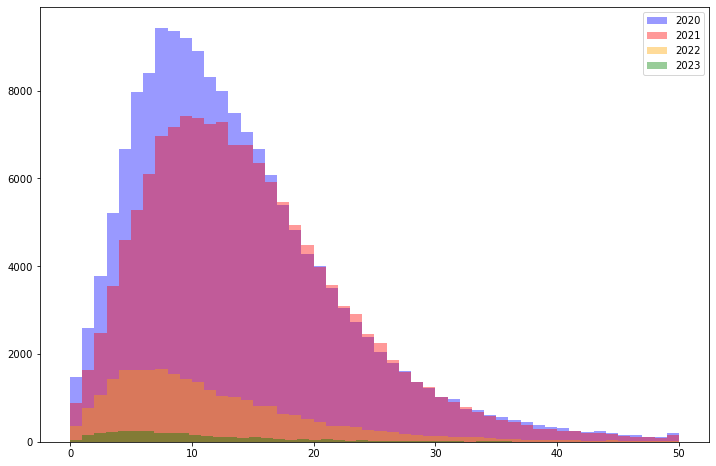

In [194]:
plt.figure(figsize=(12, 8))
plt.hist(confirmed_2020[confirmed_2020['OTD'] >= 0]['OTD'], color='blue', alpha=0.4, label='2020', bins = 50)
plt.hist(confirmed_2021[confirmed_2021['OTD'] >= 0]['OTD'], color='red', alpha=0.4, label='2021', bins = 50)
plt.hist(confirmed_2022[confirmed_2022['OTD'] >= 0]['OTD'], color='orange', alpha=0.4, label='2022', bins = 50)
plt.hist(confirmed_2023[confirmed_2023['OTD'] >= 0]['OTD'], color='green', alpha=0.4, label='2023', bins = 50)
plt.legend()
plt.show()

In [196]:
gender_dummies = pd.get_dummies(confirmed_2020['SEXO'], prefix='SEXO')
gender_dummies.columns = ['GENDER_F', 'GENDER_M']

confirmed_2020 = pd.concat([confirmed_2020, gender_dummies], axis =1)

In [212]:
grouped = confirmed_2020.groupby(['ENTIDAD_RES','FECHA_SINTOMAS'])[['GENDER_F','GENDER_M']].sum()

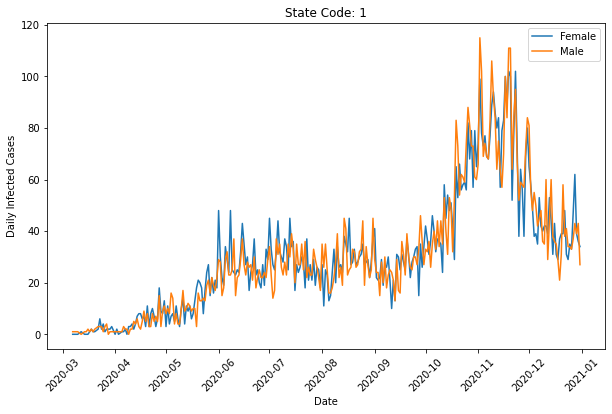

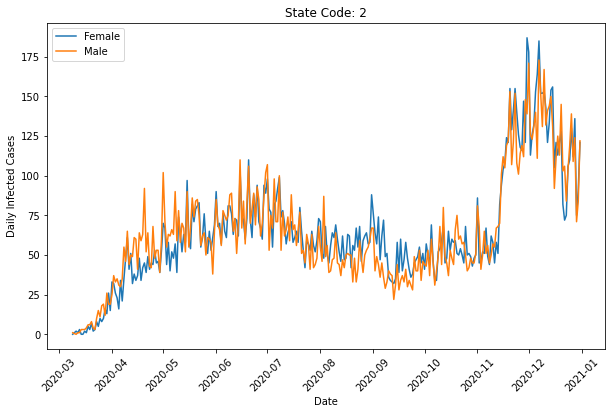

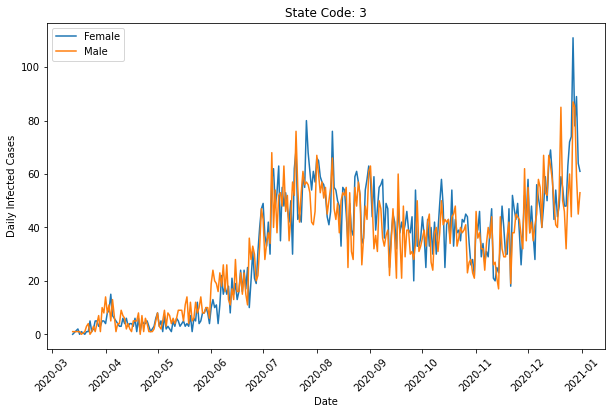

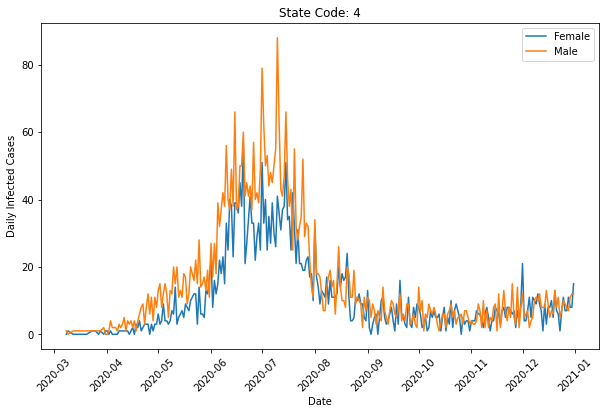

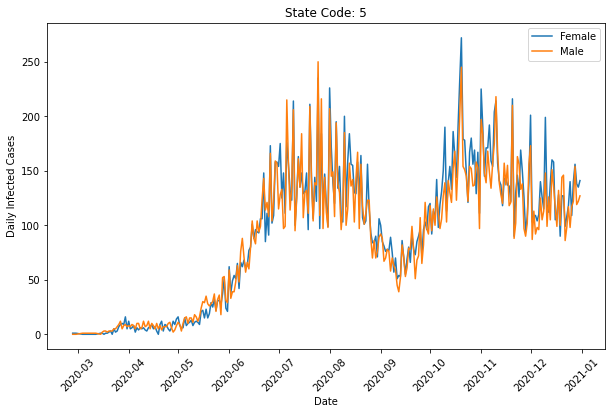

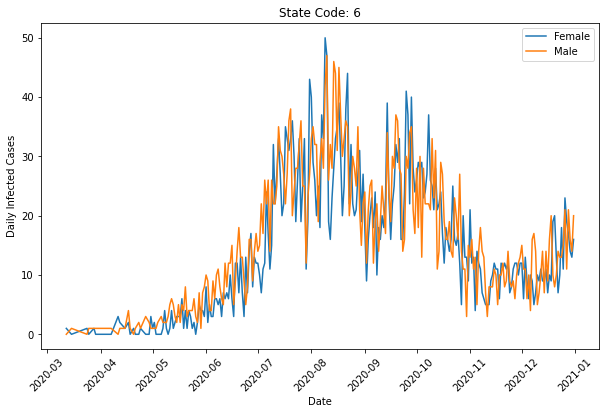

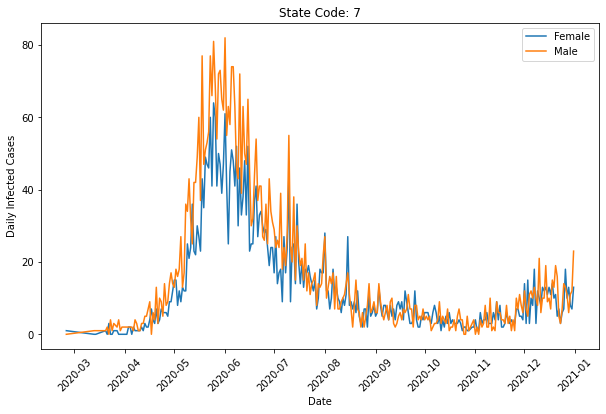

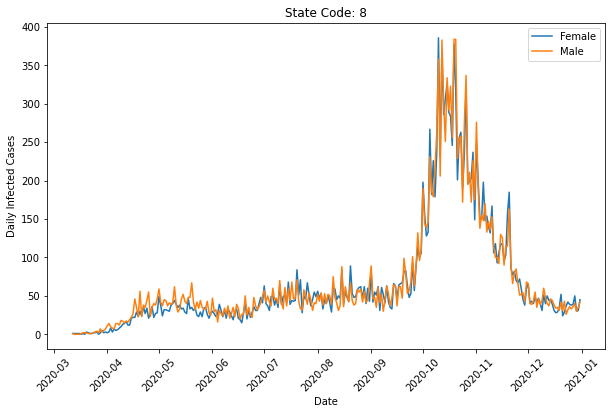

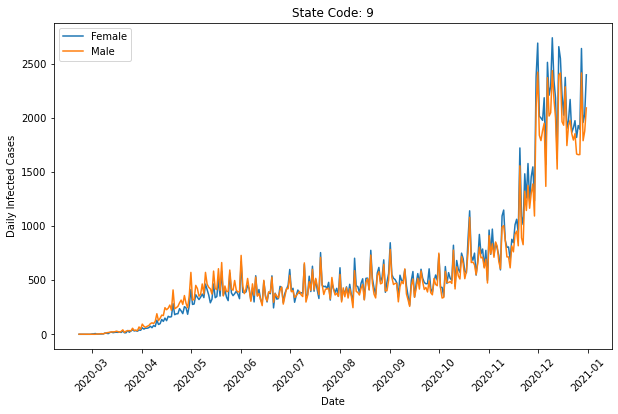

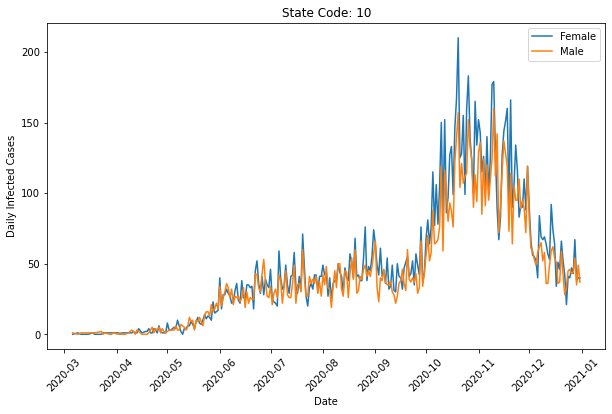

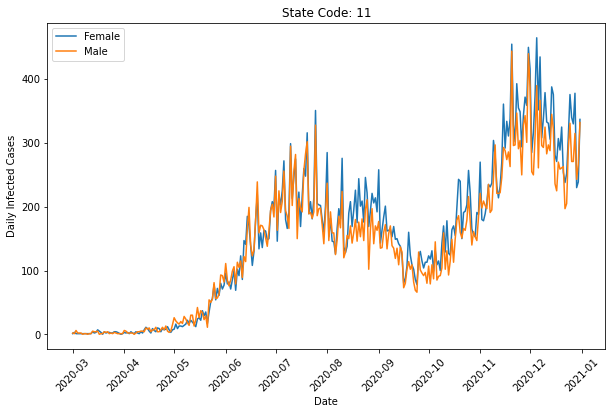

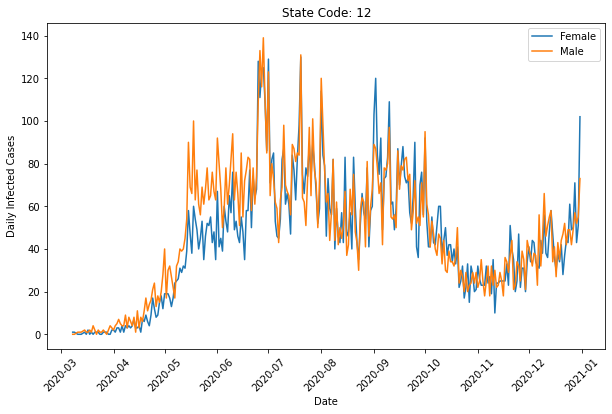

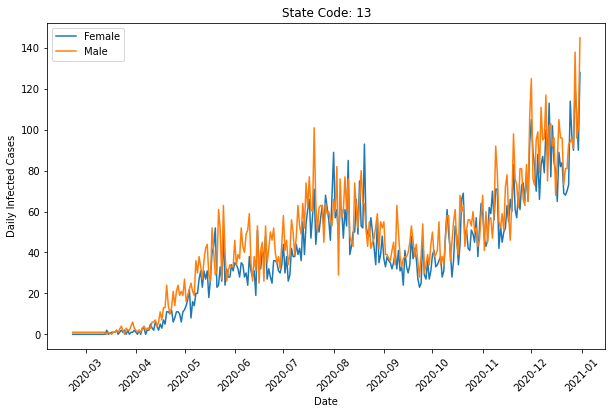

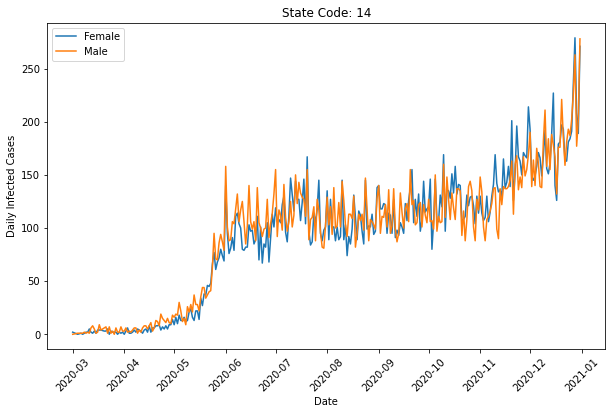

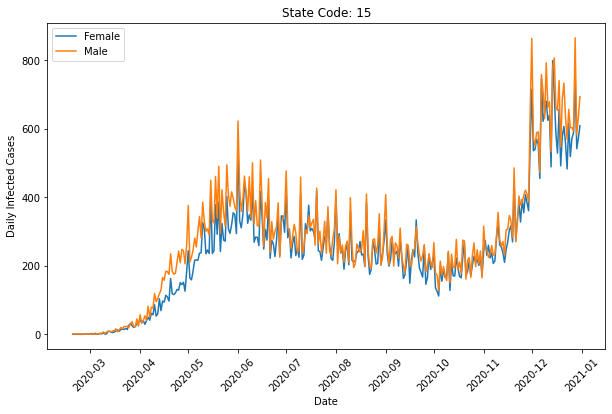

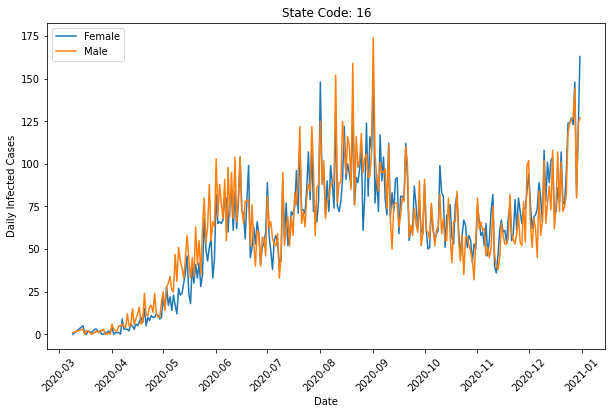

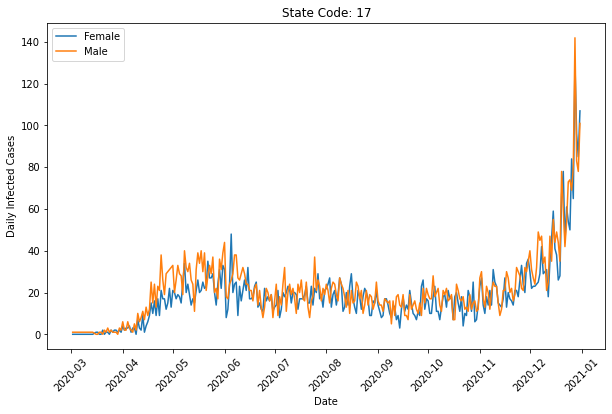

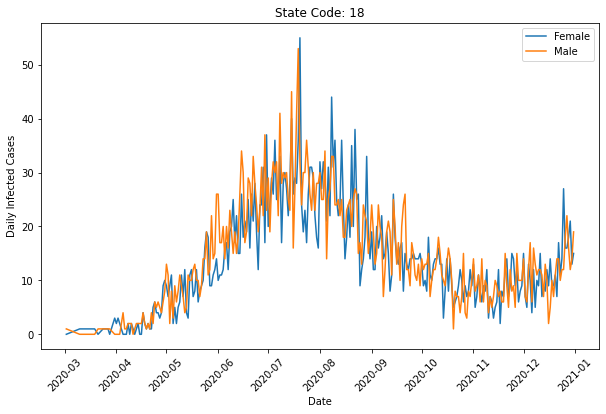

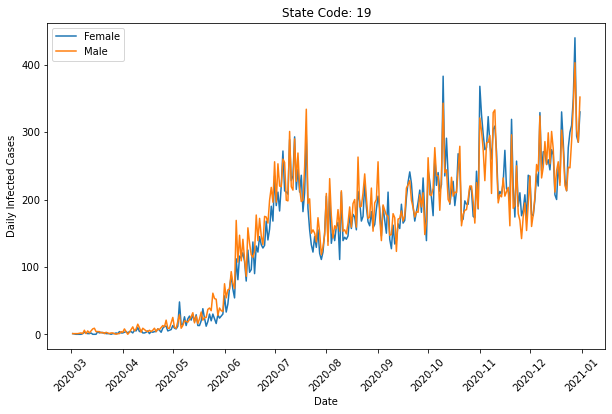

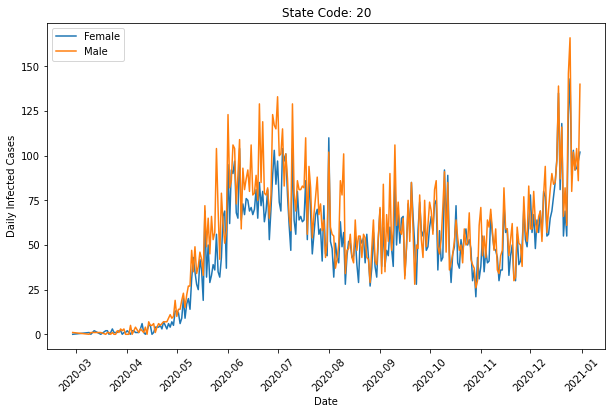

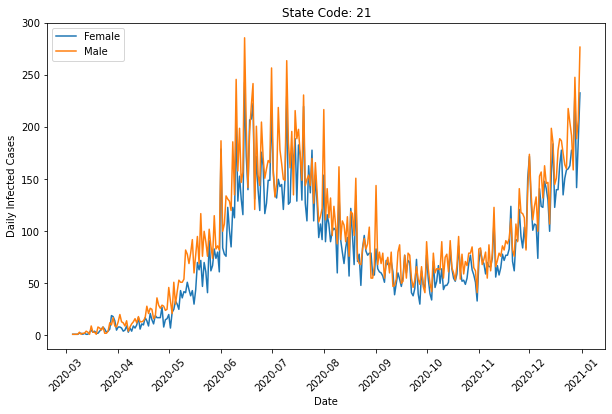

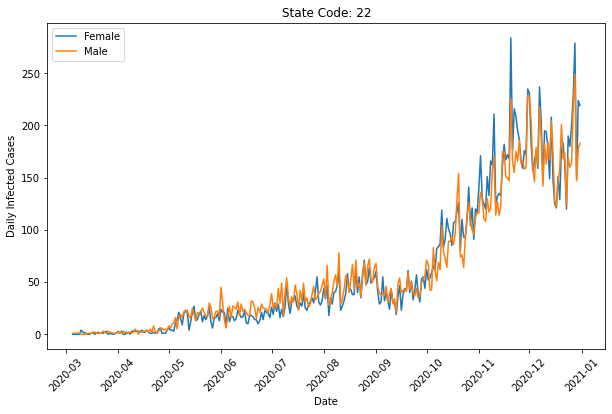

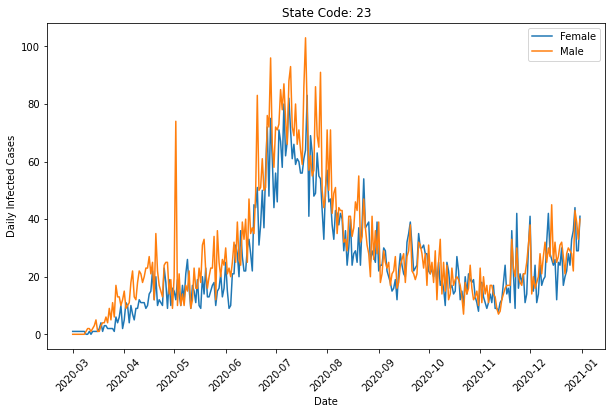

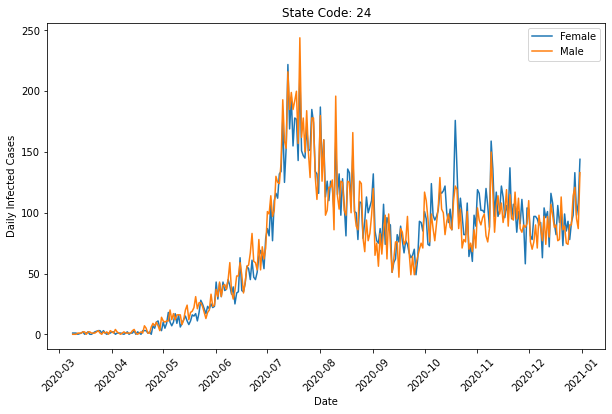

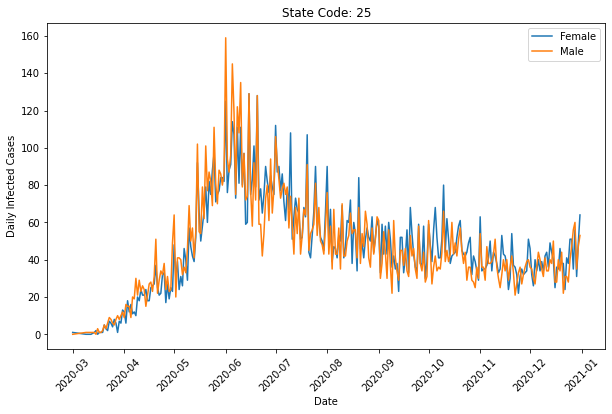

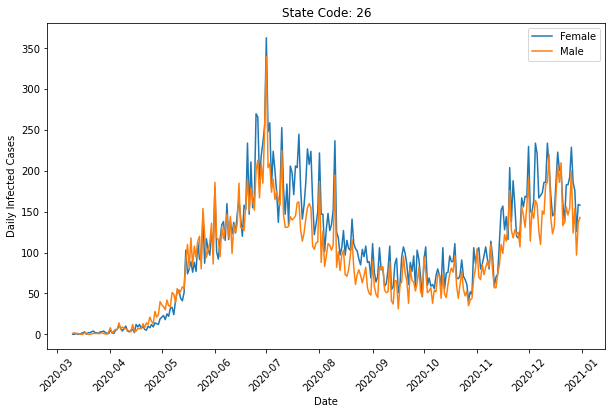

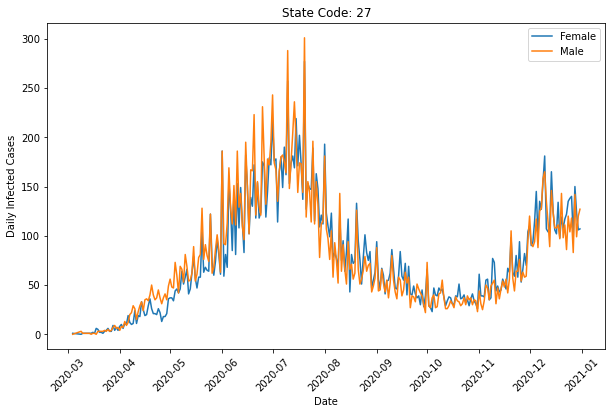

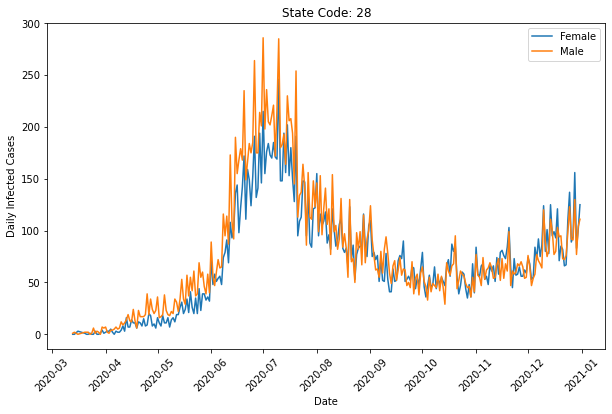

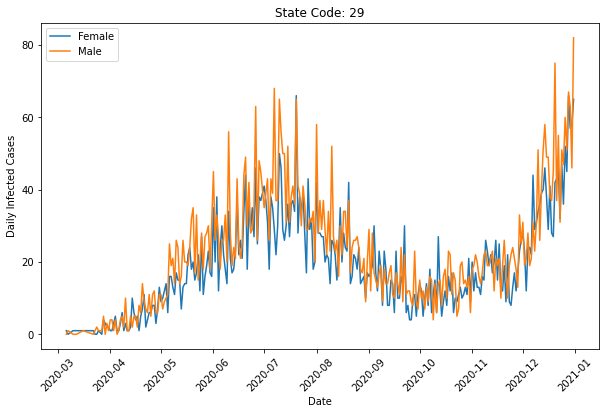

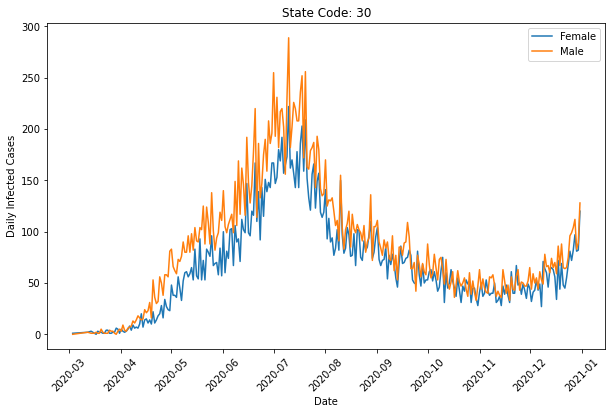

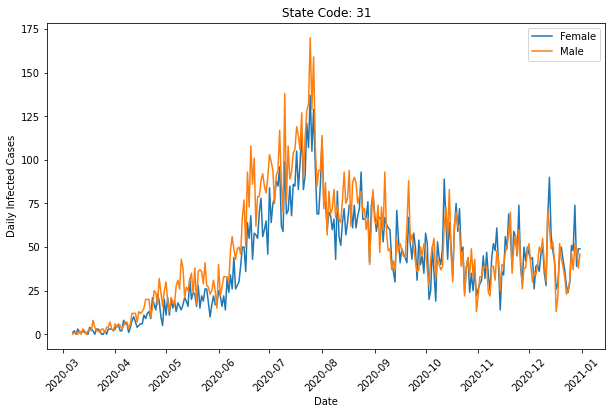

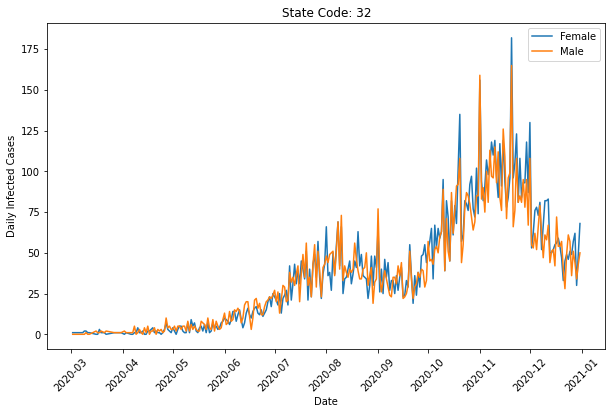

In [223]:
import matplotlib.pyplot as plt

# Iterate over each ENTIDAD_RES
for entidad_res, data in confirmed_2020.groupby('ENTIDAD_RES'):
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Filter data for the current ENTIDAD_RES
    entidad_res_data = data.groupby('FECHA_SINTOMAS')[['GENDER_F', 'GENDER_M']].sum()
    
    # Plot line for 'GENDER_F'
    ax.plot(entidad_res_data.index, entidad_res_data['GENDER_F'], label='Female')
    
    # Plot line for 'GENDER_M'
    ax.plot(entidad_res_data.index, entidad_res_data['GENDER_M'], label='Male')
    
    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Infected Cases')
    ax.set_title(f'State Code: {entidad_res}')
    
    # Add legend
    ax.legend()
    
    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45)
    
    # Show plot
    plt.show()


Text(0.5, 0, 'Date')

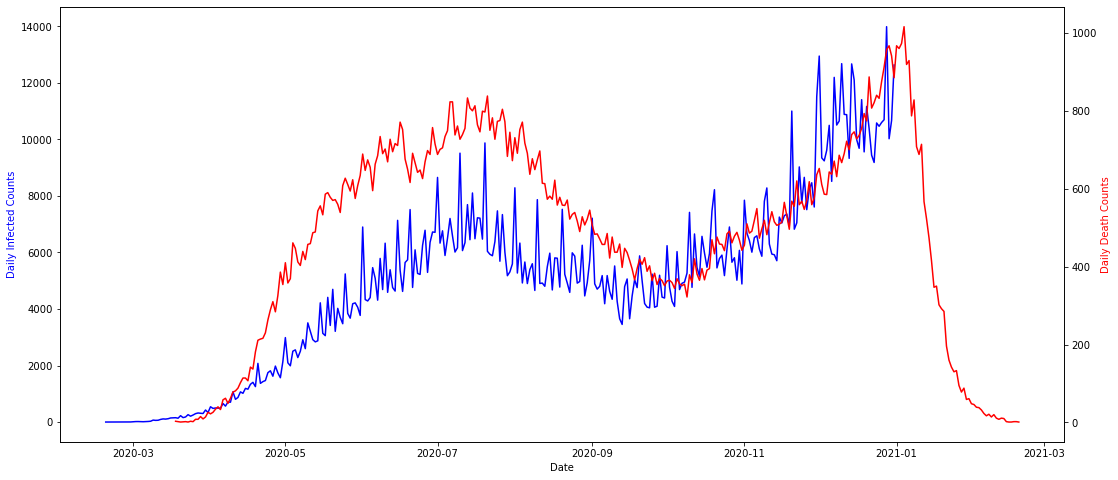

In [241]:
fig, ax1 = plt.subplots(figsize=(18, 8))

infections_2020 = confirmed_2020.groupby('FECHA_SINTOMAS').size()
diseased_2020 = confirmed_2020.groupby('FECHA_DEF').size()
    
ax1.plot(infections_2020, color = 'blue')
ax1.set_ylabel('Daily Infected Counts', color='blue')

ax2 = ax1.twinx()
ax2.plot(diseased_2020, color='red')
ax2.set_ylabel('Daily Death Counts', color='red')

ax1.set_xlabel('Date')

In [244]:
print("Mean of 2020 infected cases: {:.2f}".format(np.mean(infections_2020.values)))
print("Variance of 2020 infected cases: {:.2f}".format(np.var(infections_2020.values)))
print("Mean of 2020 deaths: {:.2f}".format(np.mean(diseased_2020.values)))
print("Variance of 2020 deaths: {:.2f}".format(np.var(diseased_2020.values)))

Mean of 2020 infected cases: 4974.17
Variance of 2020 infected cases: 9662727.93
Mean of 2020 deaths: 484.09
Variance of 2020 deaths: 64798.74


In [316]:
national_2020 = pd.concat([infections_2020.to_frame(), diseased_2020.to_frame()], axis=1)
national_2020.columns = ['Infections','Deaths']
national_2020.index = pd.to_datetime(national_2020.index)
national.head()

,FECHA,confirmed_cases,confirmed_deaths
0,2020-01-13,1.0,0.0
1,2020-01-29,1.0,0.0
2,2020-02-06,1.0,0.0
3,2020-02-19,1.0,0.0
4,2020-02-21,1.0,0.0


In [317]:
infections_2021= confirmed_2021.groupby('FECHA_SINTOMAS').size()
diseased_2021 = confirmed_2021.groupby('FECHA_DEF').size()

infections_2022 = confirmed_2022.groupby('FECHA_SINTOMAS').size()
diseased_2022 = confirmed_2022.groupby('FECHA_DEF').size()

infections_2023 = confirmed_2023.groupby('FECHA_SINTOMAS').size()
diseased_2023 = confirmed_2023.groupby('FECHA_DEF').size()

In [318]:
national_2021 = pd.concat([infections_2021.to_frame(), diseased_2021.to_frame()], axis=1)
national_2021.columns = ['Infections','Deaths']
national_2021.index = pd.to_datetime(national_2021.index)

national_2022 = pd.concat([infections_2022.to_frame(), diseased_2022.to_frame()], axis=1)
national_2022.columns = ['Infections','Deaths']
national_2022.index = pd.to_datetime(national_2022.index)

national_2023 = pd.concat([infections_2023.to_frame(), diseased_2023.to_frame()], axis=1)
national_2023.columns = ['Infections','Deaths']
national_2023.index = pd.to_datetime(national_2023.index)

In [345]:
print(national_2020[-55:-40])
print(national_2021[:15])

            Infections  Deaths
2020-12-27     10695.0   912.0
2020-12-28     13987.0   957.0
2020-12-29     10023.0   967.0
2020-12-30     10668.0   941.0
2020-12-31     12630.0   885.0
2021-01-01         NaN   967.0
2021-01-02         NaN   960.0
2021-01-03         NaN   973.0
2021-01-04         NaN  1016.0
2021-01-05         NaN   919.0
2021-01-06         NaN   929.0
2021-01-07         NaN   787.0
2021-01-08         NaN   828.0
2021-01-09         NaN   708.0
2021-01-10         NaN   688.0
            Infections  Deaths
2021-01-01     17435.0      13
2021-01-02     13746.0      30
2021-01-03     14197.0      56
2021-01-04     18691.0      93
2021-01-05     16718.0     146
2021-01-06     14620.0     228
2021-01-07     14596.0     274
2021-01-08     15820.0     365
2021-01-09     14574.0     431
2021-01-10     17194.0     519
2021-01-11     17408.0     597
2021-01-12     14773.0     665
2021-01-13     14140.0     721
2021-01-14     14169.0     793
2021-01-15     16624.0     897


In [346]:
print(national_2021[-55:-40])
print(national_2022[:15])

            Infections  Deaths
2021-12-24      5432.0     120
2021-12-25      6490.0     108
2021-12-26      8912.0     118
2021-12-27     11717.0     117
2021-12-28     11666.0     116
2021-12-29     10520.0     102
2021-12-30     11361.0      94
2021-12-31     15222.0     107
2022-01-01         NaN     108
2022-01-02         NaN     106
2022-01-03         NaN     132
2022-01-04         NaN     119
2022-01-05         NaN     107
2022-01-06         NaN     103
2022-01-07         NaN      88
            Infections  Deaths
2022-01-01     27334.0     1.0
2022-01-02     28052.0     1.0
2022-01-03     42466.0    13.0
2022-01-04     37387.0    16.0
2022-01-05     40611.0    30.0
2022-01-06     40218.0    35.0
2022-01-07     47224.0    46.0
2022-01-08     49931.0    66.0
2022-01-09     54638.0    87.0
2022-01-10     80699.0    96.0
2022-01-11     61828.0   116.0
2022-01-12     59842.0   155.0
2022-01-13     54732.0   155.0
2022-01-14     56530.0   184.0
2022-01-15     58561.0   187.0


In [347]:
print(national_2022[-55:-40])
print(national_2023[:15])

            Infections  Deaths
2022-12-14      3965.0    13.0
2022-12-15      3635.0    21.0
2022-12-16      3382.0    23.0
2022-12-17      3896.0    21.0
2022-12-18      5151.0    20.0
2022-12-19      6599.0    22.0
2022-12-20      6151.0    24.0
2022-12-21      4859.0    19.0
2022-12-22      3604.0    28.0
2022-12-23      3204.0    24.0
2022-12-24      3569.0    21.0
2022-12-25      4663.0    29.0
2022-12-26      6349.0    30.0
2022-12-27      5418.0    38.0
2022-12-28      4494.0    25.0
            Infections  Deaths
2023-01-01        5610     1.0
2023-01-02        6379     NaN
2023-01-03        5523     6.0
2023-01-04        4350    10.0
2023-01-05        3640    16.0
2023-01-06        3441    18.0
2023-01-07        3989    17.0
2023-01-08        4542    20.0
2023-01-09        5812    19.0
2023-01-10        4758    25.0
2023-01-11        3406    19.0
2023-01-12        3116    41.0
2023-01-13        2902    25.0
2023-01-14        3087    22.0
2023-01-15        4019    24.0


<AxesSubplot:>

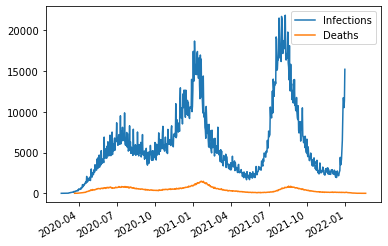

In [377]:
#Merge 2020 with 2021 data while aggregating both database info
merged_data_2021 = national_2020.merge(national_2021, how='outer', left_index=True, right_index=True, suffixes=('_2020', '_2021'))
merged_data_2021['Infections'] = merged_data_2021['Infections_2020'].add(merged_data_2021['Infections_2021'], fill_value=0)
merged_data_2021['Deaths'] = merged_data_2021['Deaths_2020'].add(merged_data_2021['Deaths_2021'], fill_value=0)
merged_data_2021.drop(columns=['Infections_2020', 'Infections_2021', 'Deaths_2020', 'Deaths_2021'], inplace=True)
merged_data_2021.plot()

<AxesSubplot:>

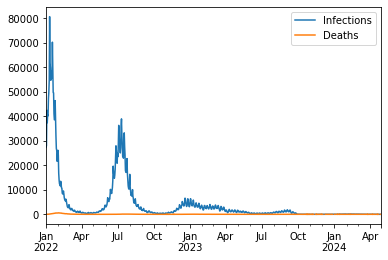

In [379]:
#Merge 2022 with 2023 data while aggregating both database info
merged_data_2023 = national_2022.merge(national_2023, how='outer', left_index=True, right_index=True, suffixes=('_2022', '_2023'))
merged_data_2023['Infections'] = merged_data_2023['Infections_2022'].add(merged_data_2023['Infections_2023'], fill_value=0)
merged_data_2023['Deaths'] = merged_data_2023['Deaths_2022'].add(merged_data_2023['Deaths_2023'], fill_value=0)
merged_data_2023.drop(columns=['Infections_2022', 'Infections_2023', 'Deaths_2022', 'Deaths_2023'], inplace=True)
merged_data_2023.plot()

In [386]:
#Consolidate everything within a single dataframe
national_daily = merged_data_2021.merge(merged_data_2023, how='outer', left_index=True, right_index=True, suffixes=('_2022', '_2023'))
national_daily['Infections'] = national_daily['Infections_2022'].add(national_daily['Infections_2023'], fill_value=0)
national_daily['Deaths'] = national_daily['Deaths_2022'].add(national_daily['Deaths_2023'], fill_value=0)
national_daily.drop(columns=['Infections_2022', 'Infections_2023', 'Deaths_2022', 'Deaths_2023'], inplace=True)

Text(0.5, 0, 'Date')

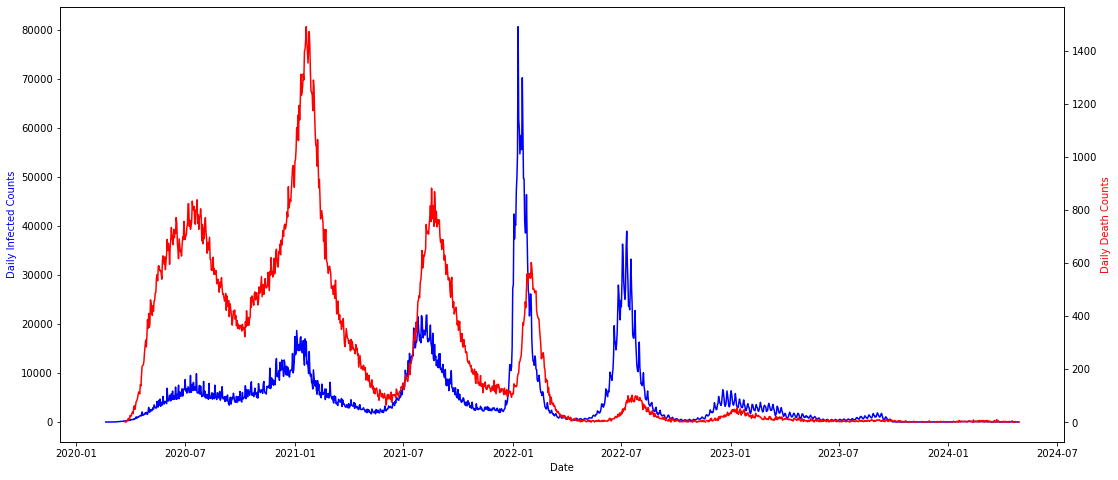

In [387]:
fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.plot(national_daily['Infections'], color = 'blue')
ax1.set_ylabel('Daily Infected Counts', color='blue')

ax2 = ax1.twinx()
ax2.plot(national_daily['Deaths'], color='red')
ax2.set_ylabel('Daily Death Counts', color='red')

ax1.set_xlabel('Date')

In [416]:
print("Mean of infected cases: {:.2f}".format(np.mean(national_daily['Infections'].values)))
print("Variance of infected cases: {:.2f}".format(np.var(national_daily['Infections'].values)))
print("Mean of deaths: {:.2f}".format(np.mean(national_daily['Deaths'].fillna(0).values)))
print("Variance of deaths: {:.2f}".format(np.var(national_daily['Deaths'].fillna(0).values)))

Mean of infected cases: 5050.47
Variance of infected cases: 64553363.04
Mean of deaths: 218.03
Variance of deaths: 90138.29


<Figure size 1440x576 with 0 Axes>

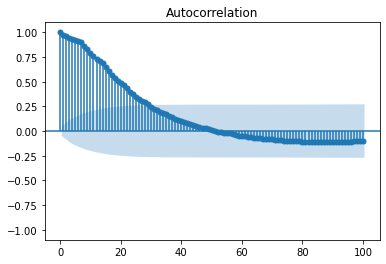

<Figure size 1296x576 with 0 Axes>

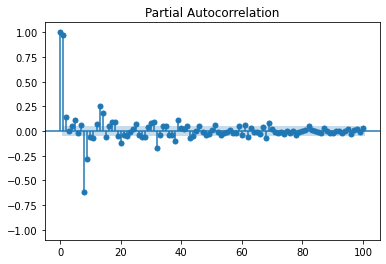

In [422]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Plot autocorrelation
plt.figure(figsize=(20,8))
plot_acf(national_daily['Infections'], lags=100)  # Change lags as needed
plt.ylim(-1.1,1.1)
plt.title('Autocorrelation')
plt.show()

plt.figure(figsize=(18, 8))
plot_pacf(national_daily['Infections'], lags=100, method='ywm')
plt.ylim(-1.1,1.1)
plt.title('Partial Autocorrelation')
plt.show()

<Figure size 1440x576 with 0 Axes>

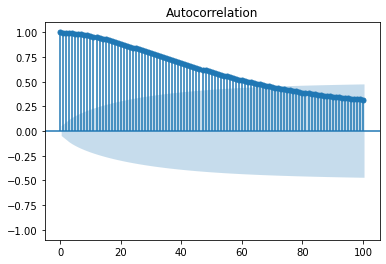

<Figure size 1296x576 with 0 Axes>

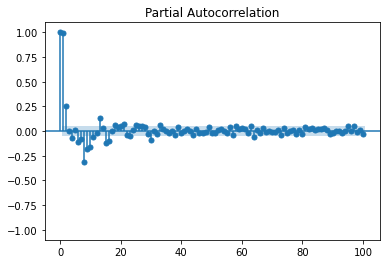

In [421]:
# Plot autocorrelation
plt.figure(figsize=(20,8))
plot_acf(national_daily['Deaths'].fillna(0), lags=100)  # Change lags as needed
plt.ylim(-1.1,1.1)
plt.title('Autocorrelation')
plt.show()

plt.figure(figsize=(18, 8))
plot_pacf(national_daily['Deaths'].fillna(0), lags=100, method='ywm')
plt.ylim(-1.1,1.1)
plt.title('Partial Autocorrelation')
plt.show()

Text(0.5, 0, 'Date')

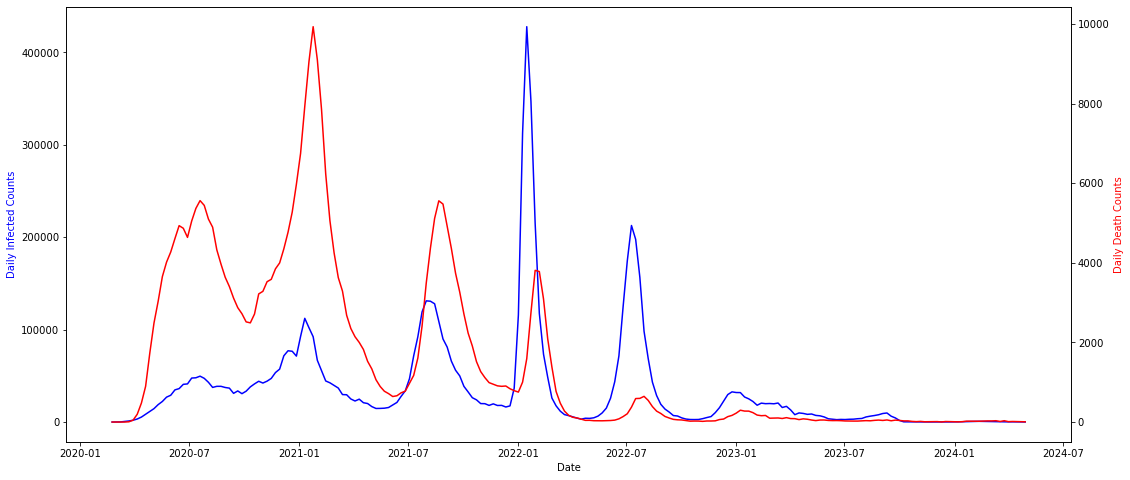

In [408]:
#Work with weekly sum to reduce variability in data and improve count accuracy
national_weekly = national.resample('W-Sun').sum()

fig, ax1 = plt.subplots(figsize=(18, 8))

ax1.plot(national_weekly['Infections'], color = 'blue')
ax1.set_ylabel('Daily Infected Counts', color='blue')


ax2 = ax1.twinx()
ax2.plot(national_weekly['Deaths'], color='red')
ax2.set_ylabel('Daily Death Counts', color='red')

ax1.set_xlabel('Date')

<Figure size 1440x576 with 0 Axes>

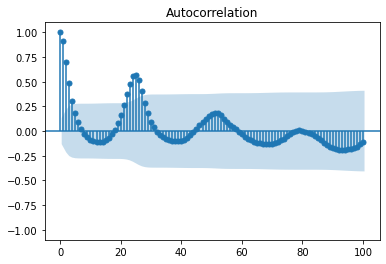

<Figure size 1296x576 with 0 Axes>

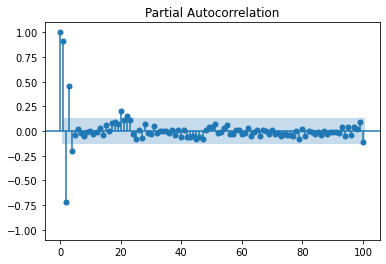

In [428]:
# Plot autocorrelation
plt.figure(figsize=(20,8))
plot_acf(national_weekly['Infections'], lags=100)  # Change lags as needed
plt.ylim(-1.1,1.1)
plt.title('Autocorrelation')
plt.show()

plt.figure(figsize=(18, 8))
plot_pacf(national_weekly['Infections'], lags=100, method='ywm')
plt.ylim(-1.1,1.1)
plt.title('Partial Autocorrelation')
plt.show()

<Figure size 1440x576 with 0 Axes>

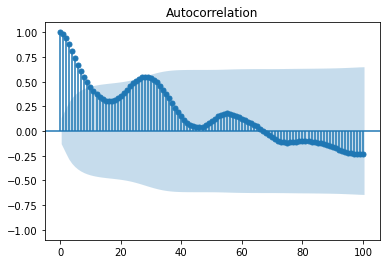

<Figure size 1296x576 with 0 Axes>

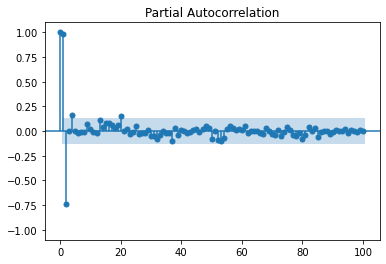

In [430]:
# Plot autocorrelation
plt.figure(figsize=(20,8))
plot_acf(national_weekly['Deaths'].fillna(0), lags=100)  # Change lags as needed
plt.ylim(-1.1,1.1)
plt.title('Autocorrelation')
plt.show()

plt.figure(figsize=(18, 8))
plot_pacf(national_weekly['Deaths'].fillna(0), lags=100, method='ywm')
plt.ylim(-1.1,1.1)
plt.title('Partial Autocorrelation')
plt.show()

### Understanding best likelihood for the data

In [452]:
national_weekly['Year'] = national_weekly.index.year
national_daily['Year'] = national_daily.index.year

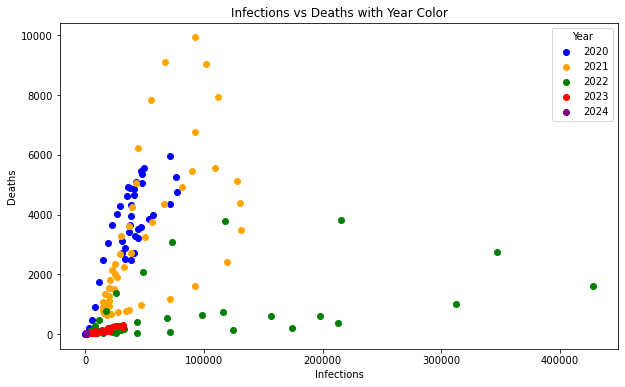

In [450]:
plt.figure(figsize=(10,6))
colors = ['blue', 'orange', 'green', 'red', 'purple']
for year, color in zip([2020, 2021, 2022, 2023, 2024], colors):
    year_data = national_weekly[national_weekly['Year'] == year]
    plt.scatter(year_data['Infections'], year_data['Deaths'], label=year, color=color)

plt.xlabel('Infections')
plt.ylabel('Deaths')
plt.title('Infections vs Deaths with Year Color')
plt.legend(title='Year')
plt.show()

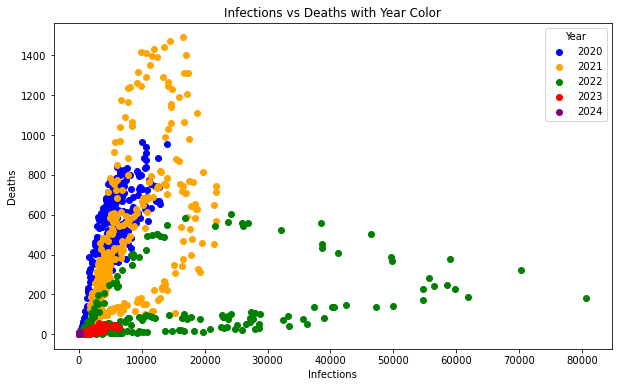

In [454]:
plt.figure(figsize=(10,6))
colors = ['blue', 'orange', 'green', 'red', 'purple']
for year, color in zip([2020, 2021, 2022, 2023, 2024], colors):
    year_data = national_daily[national_daily['Year'] == year]
    plt.scatter(year_data['Infections'], year_data['Deaths'], label=year, color=color)

plt.xlabel('Infections')
plt.ylabel('Deaths')
plt.title('Infections vs Deaths with Year Color')
plt.legend(title='Year')
plt.show()